**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***

#### Imports

In [66]:
from decouple import config
from langchain_ibm import WatsonxLLM, WatsonxEmbeddings
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters.markdown import MarkdownHeaderTextSplitter
from copy import deepcopy
from langchain_chroma import Chroma
from langchain.prompts import PromptTemplate
from langgraph.graph import START, StateGraph
from langchain_core.vectorstores.base import VectorStoreRetriever
from langchain_core.documents.base import Document
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from typing import Literal, Any
import numpy as np
from tqdm import tqdm
from IPython.display import Image, display
import litellm
from litellm import client
import instructor
from instructor import Mode
import matplotlib.pyplot as plt


# Part I: RAG

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [guides/rag_guide.ipynb](guides/rag_guide.ipynb)


***
<br>

* Remember to include some reflections on your results. Are there, for example, any hyperparameters that are particularly important?

* You should follow the steps given in the `rag_guide` notebook to create your own RAG system.

<br>

***

#### Retrieve secrets

In [67]:
WX_API_KEY = config("WX_API_KEY")
WX_PROJECT_ID = config("WX_PROJECT_ID")
WX_API_URL = "https://us-south.ml.cloud.ibm.com"


#### Authenticate and initialize LLM

In [68]:
llm = WatsonxLLM(
        # Use an embedding model to vectorize the dataset
        model_id= "meta-llama/llama-3-3-70b-instruct",
        url=WX_API_URL,
        apikey=WX_API_KEY,
        project_id=WX_PROJECT_ID,

        params={
            GenParams.DECODING_METHOD: "greedy",
            GenParams.TEMPERATURE: 0,
            GenParams.MIN_NEW_TOKENS: 5,
            GenParams.MAX_NEW_TOKENS: 1_000,
            GenParams.REPETITION_PENALTY:1.2
        }

)

#### Use LLM

In [69]:
llm_result = llm.generate(["Hi how are you?"])

print(type(llm_result))
print(llm_result)

<class 'langchain_core.outputs.llm_result.LLMResult'>
generations=[[Generation(text=' I am looking for a new job and was wondering if there is any opportunities available at your company?\nI\'m doing well, thank you! However, I need to clarify that this platform doesn\'t allow me to represent or speak on behalf of specific companies. But I can certainly help guide you through the process of finding job openings.\n\nTo find out about potential job opportunities, I recommend checking the official website of the company you\'re interested in working with. Most companies have a "Careers" or "Jobs" section where they list their current vacancies. You can also try searching for job listings on popular job boards like LinkedIn, Indeed, or Glassdoor using keywords related to the industry or role you\'re interested in.\n\nAdditionally, networking can be a great way to learn about job openings before they\'re advertised publicly. Attend industry events, join professional groups on social media, 

## Chunk and Preprocess Dataset
Split the dataset into chunks using a suitable chunking strategy and preprocess the chunks for embedding.

In [70]:
# Load dataset
document = TextLoader("data/madeup_company.md").load()[0]

# Define chunking strategy
headers_to_split_on = [("#", "Header 1"), ("##", "Header 2"), ("###", "Header 3")]
text_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
chunks = text_splitter.split_text(document.page_content)

# Preprocess chunks
def update_documents_with_headers(chunks):
    updated_chunks = []
    for doc in chunks:
        new_doc = deepcopy(doc)
        headers = [new_doc.metadata.get(f"Header {i}") for i in range(1, 4) if f"Header {i}" in new_doc.metadata]
        if headers:
            prefix = f"[{'/'.join(headers)}]: "
            new_doc.page_content = prefix + "\n" + new_doc.page_content
        updated_chunks.append(new_doc)
    return updated_chunks

docs = update_documents_with_headers(chunks)

## Store Vectors in a Vector Index
Store the vectorized chunks in a vector index using LangChain's Chroma.

In [71]:
embed_params = {}

watsonx_embedding = WatsonxEmbeddings(
    model_id="ibm/granite-embedding-278m-multilingual",
    url=WX_API_URL,
    project_id=WX_PROJECT_ID,
    apikey=WX_API_KEY,
    params=embed_params,
)

# Create vector index
vector_index = Chroma.from_documents(
    collection_name="my_collection",
    embedding=watsonx_embedding,
    persist_directory="my_vector_db_1", # This will save the vector database to disk! Delete it if you want to start fresh.
    documents=docs,
    
)

## Retrieve Similar Documents
Use the vector index to retrieve the most similar documents to a given query using semantic search.

In [72]:
# Retrieve documents
retriever = vector_index.as_retriever(search_type="similarity", search_kwargs={"k": 3})
query = "Tell me about MadeUpCompany"
retrieved_docs = retriever.invoke(query)

# Display retrieved documents
for document in retrieved_docs:
    print(f"{'#' * 80}\nID: {document.id}")
    first_n_of_content = document.page_content[:500].replace('\n\n', ' ')
    print(f"Content: {first_n_of_content}\n")


################################################################################
ID: 025a5a00-26a0-4484-b130-947051574310
Content: [About MadeUpCompany/Contact]: 
For more information, visit our website at www.madeupcompany.com or contact our sales team at sales@madeupcompany.com. 🚀

################################################################################
ID: 3a85dbd1-77c5-4b22-8b91-2ee4a5709738
Content: [About MadeUpCompany/Contact]: 
For more information, visit our website at www.madeupcompany.com or contact our sales team at sales@madeupcompany.com. 🚀

################################################################################
ID: 9e7972bd-049b-417b-a2ca-e707afca132f
Content: [About MadeUpCompany/Contact]: 
For more information, visit our website at www.madeupcompany.com or contact our sales team at sales@madeupcompany.com. 🚀



## Generate Response Using Retrieved Context
Pass the retrieved documents as context to the LLM and generate a response to the query.

In [73]:
# Define prompt template
template = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

Question:
{question}

Context:
{context}

Answer:"""
prompt = PromptTemplate.from_template(template)

# Generate response
context = "\n\n".join(f"Document {i+1}:\n{doc.page_content}" for i, doc in enumerate(retrieved_docs))
formatted_prompt = prompt.invoke({"question": query, "context": context})
response = llm.invoke(formatted_prompt)

# Print prompt and answer
print("Full promp:", formatted_prompt.to_string()[:1000])
print("response:", response)

Full promp: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

Question:
Tell me about MadeUpCompany

Context:
Document 1:
[About MadeUpCompany/Contact]: 
For more information, visit our website at www.madeupcompany.com or contact our sales team at sales@madeupcompany.com. 🚀

Document 2:
[About MadeUpCompany/Contact]: 
For more information, visit our website at www.madeupcompany.com or contact our sales team at sales@madeupcompany.com. 🚀

Document 3:
[About MadeUpCompany/Contact]: 
For more information, visit our website at www.madeupcompany.com or contact our sales team at sales@madeupcompany.com. 🚀

Answer:
response:  I don't know much about MadeUpCompany except that their website is www.madeupcompany.com and they have a sales email address (sales@madeupcompany.com). The provided documents only cont

## RAG Pieline

In [74]:
# Define state for application
class State(TypedDict):
    """ A langgraph state for the application """
    question: str
    context: list[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    """ Our retrieval step. We use our local vector database to retrieve similar documents to the question """
    retrieved_docs = vector_index.similarity_search(state["question"], k=3) # NOTE: You can change k to retrieve fewer or more documents
    return {"context": retrieved_docs} 


def generate(state: State):
    """ Our generation step. We use the retrieved documents to generate an answer to the question """

    # Format the prompt
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    formated_prompt = prompt.invoke({"question": state["question"], "context": docs_content})

    # Generate the answer
    response = llm.invoke(formated_prompt)
    return {"answer": response}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve") # Start at the retrieve step
graph = graph_builder.compile() # Compile the graph


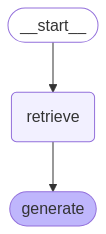

In [75]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Evaluate RAG System
Evaluate the RAG system using metrics such as retrieval quality, answer correctness, and hallucination score.

In [78]:

# create a litellm client
litellm.drop_params = True  # watsonx.ai doesn't support `json_mode`
client = instructor.from_litellm(completion, mode=Mode.JSON)

# create a response model - LLM is forced to return an object of this type
class JudgeResponse(BaseModel):
    reasoning: str = Field(description="Short one-sentence reason for score")
    score: Literal[0, .5, 1] = Field(description="Final score")

# define a function to call the judge
def call_judge(prompt : str) -> JudgeResponse:
    response = client.chat.completions.create(
        model="watsonx/meta-llama/llama-3-3-70b-instruct",
        max_tokens=1024,
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        project_id=WX_PROJECT_ID,
        apikey=WX_API_KEY,
        api_base=WX_API_URL,
        response_model=JudgeResponse,
        # decoding_method="greedy",
        # temperature=0,
    )
    return response

class RAGEvaluator:
    """
    A streamlined evaluator for RAG systems focusing on three key dimensions:
    1. Retrieval Quality
    2. Answer Correctness
    3. Hallucination Detection
    """
    def __init__(self, llm_func):
        """Initialize with an LLM."""
        self.llm_func = llm_func
            
    def evaluate_retrieval_quality(self, response: dict[str, Any], expected_answer: str, verbose : bool = False) -> JudgeResponse:
        """
        Ask LLM if retrieved documents contain information needed for the expected answer.
        """
        # Combine all retrieved document contents with clear formatting
        retrieved_text = "\n\n".join([f"Document {i+1}:\n{doc.page_content}" for i, doc in enumerate(response.get('context', []))])
        
        prompt = f"""You are given a set of documents and a fact. Can the fact be found in the documents? Judge by the information, not the exact wording of the fact.
        
        - Respond with 1 if the fact is present (also if the fact can be pieced together from multiple documents).
        - Respond with 0 if the fact is not present in any of the documents.
        - Responds with 0.5 ff only part of the fact is present.
        
        Retrieved Documents: 
        {retrieved_text}

        Fact:
        {expected_answer}
        
        Can the fact be found in the documents? Respond as a JudgeResponse object with: 
        - a short reason (max 20 words)
        - a score of 1, 0.5, or 0.
        """
        
        result = self.llm_func(prompt)
        if verbose:
            print(f"[evaluation_retrieval_quality] LLM response: {result}")
        return result
    
    def evaluate_answer_correctness(self, response: dict[str, Any], expected_answer: str, verbose : bool = False) -> JudgeResponse:
        """
        Ask LLM to rate how correct/similar the generated answer is to the expected answer.
        """
        generated_answer = response.get('answer', '')
        
        prompt = f"""You are evaluating a RAG system. You are given a question, an expected answer, and a generated answer. Is the generated answer as correct - or close to as correct - as the expected answer? 
        
        - Respond with 1 if the answer is yes (also if the answer is more detailed than expected)
        - Respond with 0 if the answer is no. 
        - respond with 0.5 if the generated answer is partially correct

        Question:
        {response.get('question', '')}
        
        Expected answer:
        {expected_answer}
        
        Generated answer:
        {generated_answer}
        
        Is the generated answer correct enough? Consider content correctness rather than exact wording. 
        Respond as a JudgeResponse object with: 
        - a short reason (max 20 words)
        - a score of 1, 0.5, or 0."""
        
        result = self.llm_func(prompt)
        if verbose:
            print(f"[evaluation_answer_correctness] LLM response: {result}")
        return result
    
    def evaluate_hallucination(self, response: dict[str, Any], verbose : bool = False) -> JudgeResponse:
        """
        Ask LLM to evaluate if the answer contains hallucinations.
        """
        generated_answer = response.get('answer', '')
        retrieved_text = "\n\n".join([f"Document {i+1}:\n{doc.page_content}" for i, doc in enumerate(response.get('context', []))])
        
        prompt = f"""You are evaluating a RAG system. Your task is to determine if the generated answer contains hallucinations. Hallucinations are any information that is not directly supported by the retrieved documents. Does the generated answer contain hallucinations? 
        
        - If the answer is no, respond with 0. 
        - If the answer is yes, respond with 1.
        - If the answer is partially hallucinated, respond with 0.5. 
        - If the generated answer states that it does not know, respond with 0.

        Question: 
        {response.get('question', '')}
        
        Retrieved context (this is all the information the AI had access to):
        {retrieved_text}
        
        Generated answer:
        {generated_answer}
        
        Does the generated answer contain hallucinations? Respond as a JudgeResponse object with: 
        - a short reason (max 20 words)
        - a score of 1, 0.5, or 0.
        """
        
        result = self.llm_func(prompt)
        if verbose:
            print(f"[evaluation_hallucination] LLM response: {result}")
        return result
    
    def evaluate(self, response: dict[str, Any], expected_answer: str, verbose : bool = False) -> dict[str, Any]:
        """
        Evaluate a RAG response across all three dimensions.
        """
        # Get scores for each dimension
        retrieval_score = self.evaluate_retrieval_quality(response, expected_answer, verbose=verbose)
        correctness_score = self.evaluate_answer_correctness(response, expected_answer, verbose=verbose)
        hallucination_score = self.evaluate_hallucination(response, verbose=verbose)
        
        return {
            "query": response.get("question", ""),
            "retrieved_context": response.get("context", []),
            "generated_answer": response.get("answer", ""),
            "expected_answer": expected_answer,
            "retrieval_quality": retrieval_score.score,
            "answer_correctness": correctness_score.score, 
            "hallucination_score": hallucination_score.score,  # Lower is better

            # keep the reasoning for manual inspection
            "retrieval_quality_reasoning": retrieval_score.reasoning,
            "answer_correctness_reasoning": correctness_score.reasoning,
            "hallucination_reasoning": hallucination_score.reasoning
        }


def evaluate_rag_system(graph, test_queries, expected_responses, evaluator, verbose=False):
    """
    Evaluate a RAG system on a test set.
    
    Args:
        graph: The LangGraph RAG system with invoke method
        test_queries: List of questions to test
        expected_responses: List of expected answers
        evaluator: The RAG evaluator object
        
    Returns:
        Evaluation results
    """
    results = []
    
    for query, expected in tqdm(zip(test_queries, expected_responses), total=len(test_queries)):

        # Get RAG response
        response = graph.invoke({"question": query})
        
        # Evaluate
        eval_result = evaluator.evaluate(response, expected, verbose=verbose)
        results.append(eval_result)
    
    # Calculate average scores
    avg_metrics = {
        "retrieval_quality": np.mean([r["retrieval_quality"] for r in results]),
        "answer_correctness": np.mean([r["answer_correctness"] for r in results]),
        "hallucination": np.mean([r["hallucination_score"] for r in results])
    }

    return {
        "individual_results": results,
        "scores": avg_metrics,
        "num_queries": len(test_queries)
    }
    
# Samples for evaluation
sample_queries = [
    "When was MadeUpCompany founded and where is it headquartered?",
    "What security features does CloudMate offer for enterprise customers?",
    "How much does the Professional plan for CloudMate cost and what storage capacity does it include?",
    "What analytics capabilities does DataWiz provide for business intelligence?",
    "What compliance standards does MadeUpCompany adhere to?",
    "What channels are available for technical support at MadeUpCompany?",
    "What is MadeUpCompany's refund policy for the first 30 days?",
    "What upcoming collaboration features is MadeUpCompany planning for CloudMate?",
    "Where are MadeUpCompany's satellite offices located?",
    "What four core values does MadeUpCompany believe in?",
    "What professional backgrounds do MadeUpCompany's experts come from?",
    "What does the Starter plan for DataWiz include and how much does it cost?",
    "How quickly does MadeUpCompany promise to resolve technical issues?",
    "What account management features are available through MadeUpCompany's online portal?",
    "How many users does MadeUpCompany have and what publications have featured them?",
    "What types of custom AI solutions does MadeUpCompany develop?",
    "What encryption standard does MadeUpCompany use and where is it applied?",
    "What are the specifications of the Basic plan for CloudMate?",
    "What is the guaranteed response time for email support at MadeUpCompany?",
    "What capabilities does DataWiz offer for fraud prevention?",
    "How does MadeUpCompany's cancellation policy work after the 30-day period?",
    "What machine learning capabilities will DataWiz introduce in upcoming features?",
    "What pricing plan options are available for MadeUpCompany's Enterprise customers?",
    "What does MadeUpCompany's sustainability value focus on?",
    "How does MadeUpCompany describe its mission?"
]

expected_responses = [
    "MadeUpCompany was founded in 2010 and is headquartered in San Francisco, California.",
    "CloudMate offers military-grade encryption, multi-factor authentication, and role-based access control for enterprise security.",
    "The Professional plan for CloudMate costs $29.99/month and includes 1TB of storage, enhanced security, and priority support.",
    "DataWiz provides predictive analytics for demand forecasting and customer behavior modeling, real-time dashboards with customizable reporting, API integrations with popular business intelligence tools, and automated anomaly detection.",
    "MadeUpCompany adheres to GDPR, HIPAA, and SOC 2 compliance standards for global security and data protection compliance.",
    "MadeUpCompany offers toll-free phone support, live chat assistance, email support, comprehensive FAQ and user guides on their website, and a community forum for peer-to-peer discussions.",
    "MadeUpCompany offers a 30-day money-back guarantee on all plans, allowing customers to request a full refund if they're not satisfied within the first 30 days.",
    "MadeUpCompany is planning to introduce enhanced real-time document editing and team workspaces for seamless collaboration in CloudMate.",
    "MadeUpCompany has satellite offices in New York, London, and Tokyo.",
    "MadeUpCompany believes in innovation, security & privacy, a customer-centric approach, and sustainability.",
    "MadeUpCompany's experts come from various industries including AI research, cybersecurity, and enterprise software development.",
    "The Starter plan for DataWiz costs $49/month and includes basic analytics and limited AI insights.",
    "MadeUpCompany resolves most technical issues within 24 hours, ensuring minimal downtime for businesses.",
    "Through MadeUpCompany's online portal, customers can upgrade or downgrade plans, access billing history and download invoices, manage multiple users and set role-based permissions, and track storage and analytics usage in real time.",
    "MadeUpCompany has over 1 million satisfied users worldwide and has been featured in TechCrunch, Forbes, and Wired as a top innovator.",
    "MadeUpCompany provides tailored machine learning models including NLP-based chatbots and AI-driven recommendation engines to optimize business workflows, automate repetitive tasks, and enhance decision-making.",
    "MadeUpCompany uses AES-256 encryption to protect data both in transit and at rest.",
    "The Basic plan for CloudMate costs $9.99/month and includes 100GB storage and essential security features.",
    "MadeUpCompany guarantees an email support response within 6 hours.",
    "DataWiz provides automated anomaly detection for fraud prevention and operational efficiency.",
    "After 30 days, customers may cancel their subscription at any time, and MadeUpCompany will issue a prorated refund based on the remaining subscription period.",
    "DataWiz will introduce automated trend forecasting powered by deep learning.",
    "MadeUpCompany offers custom pricing for Enterprise plans with unlimited storage, advanced compliance tools, and a dedicated account manager for CloudMate, and full AI customization with dedicated data scientists for DataWiz.",
    "MadeUpCompany's sustainability value focuses on ensuring their infrastructure is energy-efficient and environmentally responsible.",
    "MadeUpCompany's mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation."
]
    

In [79]:

results = evaluate_rag_system(
    graph, 
    sample_queries,
    expected_responses,
    evaluator=RAGEvaluator(llm_func=call_judge),
    verbose=True
)

results["scores"]

  0%|          | 0/25 [00:00<?, ?it/s]

[evaluation_retrieval_quality] LLM response: reasoning='Fact matches documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Answer is correct and more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Answer is correct and more detailed' score=1


  4%|▍         | 1/25 [00:13<05:16, 13.18s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches CloudMate features' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches CloudMate features' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


  8%|▊         | 2/25 [00:28<05:36, 14.61s/it]

[evaluation_hallucination] LLM response: reasoning='Mentions business continuity' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Exact match found' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Exact match found' score=1
[evaluation_answer_correctness] LLM response: reasoning='Matches expected content' score=1
[evaluation_answer_correctness] LLM response: reasoning='Matches expected content' score=1


 12%|█▏        | 3/25 [00:41<05:03, 13.81s/it]

[evaluation_hallucination] LLM response: reasoning='Extra information about plan positioning' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_answer_correctness] LLM response: reasoning='Similar content, more detail' score=1
[evaluation_answer_correctness] LLM response: reasoning='Similar content, more detail' score=1


 16%|█▌        | 4/25 [00:53<04:36, 13.18s/it]

[evaluation_hallucination] LLM response: reasoning='No unsourced information' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 20%|██        | 5/25 [01:04<04:06, 12.33s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 24%|██▍       | 6/25 [01:15<03:43, 11.74s/it]

[evaluation_hallucination] LLM response: reasoning='No extra information' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact stated in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact stated in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 28%|██▊       | 7/25 [01:26<03:30, 11.70s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 32%|███▏      | 8/25 [01:39<03:21, 11.87s/it]

[evaluation_hallucination] LLM response: reasoning='No hallucinations found' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 36%|███▌      | 9/25 [01:51<03:10, 11.88s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed, same content' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed, same content' score=1


 40%|████      | 10/25 [02:01<02:53, 11.56s/it]

[evaluation_hallucination] LLM response: reasoning='Minor rephrasing' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 44%|████▍     | 11/25 [02:15<02:52, 12.34s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 48%|████▊     | 12/25 [02:27<02:36, 12.01s/it]

[evaluation_hallucination] LLM response: reasoning='Added unsupplied plan context' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact stated in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact stated in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 52%|█████▏    | 13/25 [02:38<02:20, 11.72s/it]

[evaluation_hallucination] LLM response: reasoning='Answer supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 56%|█████▌    | 14/25 [02:49<02:08, 11.64s/it]

[evaluation_hallucination] LLM response: reasoning='Answer fully supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is accurate' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is accurate' score=1


 60%|██████    | 15/25 [03:00<01:53, 11.34s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 64%|██████▍   | 16/25 [03:11<01:40, 11.15s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 68%|██████▊   | 17/25 [03:24<01:34, 11.85s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 72%|███████▏  | 18/25 [03:39<01:29, 12.73s/it]

[evaluation_hallucination] LLM response: reasoning='Adds interpretation of plan suitability' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches email support guarantee' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches email support guarantee' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 76%|███████▌  | 19/25 [03:54<01:20, 13.40s/it]

[evaluation_hallucination] LLM response: reasoning='Added resolution time detail' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 80%|████████  | 20/25 [04:08<01:07, 13.55s/it]

[evaluation_hallucination] LLM response: reasoning='Some details not supported' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Fact is fully present' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact is fully present' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 84%|████████▍ | 21/25 [04:20<00:52, 13.10s/it]

[evaluation_hallucination] LLM response: reasoning='Minor expansion of existing info' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='No trend forecasting mentioned' score=0
[evaluation_retrieval_quality] LLM response: reasoning='No trend forecasting mentioned' score=0
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is incorrect' score=0
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is incorrect' score=0


 88%|████████▊ | 22/25 [04:32<00:38, 12.81s/it]

[evaluation_hallucination] LLM response: reasoning='No new info introduced' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Only flexible pricing mentioned' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Only flexible pricing mentioned' score=0
[evaluation_answer_correctness] LLM response: reasoning='Generated answer lacks specific details' score=0
[evaluation_answer_correctness] LLM response: reasoning='Generated answer lacks specific details' score=0


 92%|█████████▏| 23/25 [04:47<00:26, 13.46s/it]

[evaluation_hallucination] LLM response: reasoning='Answer admits lack of knowledge' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 96%|█████████▌| 24/25 [04:58<00:12, 12.81s/it]

[evaluation_hallucination] LLM response: reasoning='Added prioritizing detail' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


100%|██████████| 25/25 [05:12<00:00, 12.49s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0


{'retrieval_quality': 0.92, 'answer_correctness': 0.92, 'hallucination': 0.24}

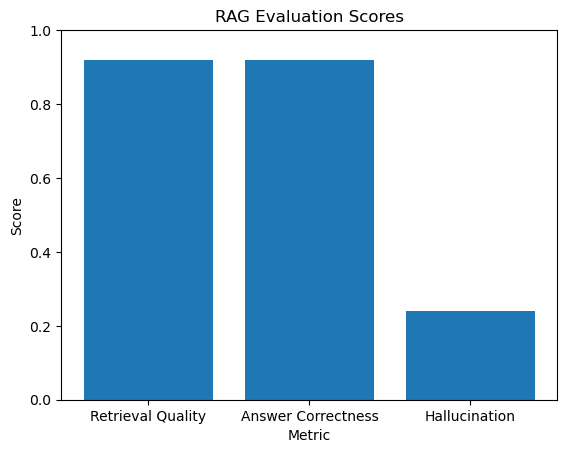

In [80]:
def plot_scores(scores):
    """
    Plot the evaluation scores.
    """
    labels = ["Retrieval Quality", "Answer Correctness", "Hallucination"]
    scores = [scores["retrieval_quality"], scores["answer_correctness"], scores["hallucination"]]
    
    _, ax = plt.subplots()
    ax.bar(labels, scores)
    ax.set_xlabel('Metric')
    # set y range to 0-1
    ax.set_ylim(0, 1)
    ax.set_ylabel('Score')
    ax.set_title('RAG Evaluation Scores')
    plt.show()

plot_scores(results["scores"])

In [81]:
results["individual_results"][:5]

[{'query': 'When was MadeUpCompany founded and where is it headquartered?',
  'retrieved_context': [Document(id='4b2b4488-cd9e-451c-8835-583f9617a416', metadata={'Header 1': 'About MadeUpCompany'}, page_content='[About MadeUpCompany]: \nMadeUpCompany is a pioneering technology firm founded in 2010, specializing in cloud computing, data analytics, and machine learning. Headquartered in San Francisco, California, we have a global presence with satellite offices in New York, London, and Tokyo. Our mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation.  \nWith a diverse team of experts from various industries—including AI research, cybersecurity, and enterprise software development—we push the boundaries of what’s possible. Our commitment to continuous improvement, security, and customer success has earned us recognition as a leader in the tech space.'),
   Document(id='891efd52-009b-4d26-9d2a-1a844c114030', meta

## Experiment with Hyperparameters


In [82]:
# Adjustement 1: Adjust top-k retrieval
retriever = vector_index.as_retriever(search_type="similarity", search_kwargs={"k": 5})
retrieved_docs = retriever.invoke(query)

In [83]:

results = evaluate_rag_system(
    graph, 
    sample_queries,
    expected_responses,
    evaluator=RAGEvaluator(llm_func=call_judge),
    verbose=True
)

results["scores"]

  0%|          | 0/25 [00:00<?, ?it/s]

[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Answer is correct and more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Answer is correct and more detailed' score=1


  4%|▍         | 1/25 [00:12<05:10, 12.93s/it]

[evaluation_hallucination] LLM response: reasoning='No extra information' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches CloudMate features' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches CloudMate features' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


  8%|▊         | 2/25 [00:23<04:21, 11.36s/it]

[evaluation_hallucination] LLM response: reasoning='Mentions business continuity' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in all documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in all documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Matches expected content' score=1
[evaluation_answer_correctness] LLM response: reasoning='Matches expected content' score=1


 12%|█▏        | 3/25 [00:35<04:17, 11.72s/it]

[evaluation_hallucination] LLM response: reasoning='Extra information about plan position' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully described' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully described' score=1
[evaluation_answer_correctness] LLM response: reasoning='Similar content, more details' score=1
[evaluation_answer_correctness] LLM response: reasoning='Similar content, more details' score=1


 16%|█▌        | 4/25 [00:47<04:13, 12.08s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is fully supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact explicitly mentioned' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact explicitly mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 20%|██        | 5/25 [00:59<03:58, 11.95s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported information' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is accurate' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is accurate' score=1


 24%|██▍       | 6/25 [01:13<04:00, 12.63s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is fully supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact stated in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact stated in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 28%|██▊       | 7/25 [01:24<03:34, 11.91s/it]

[evaluation_hallucination] LLM response: reasoning='No extra info added' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 32%|███▏      | 8/25 [01:36<03:23, 11.96s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 36%|███▌      | 9/25 [01:48<03:10, 11.93s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Matching values found' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Matching values found' score=1
[evaluation_answer_correctness] LLM response: reasoning='Fully correct with extra detail' score=1
[evaluation_answer_correctness] LLM response: reasoning='Fully correct with extra detail' score=1


 40%|████      | 10/25 [02:04<03:18, 13.21s/it]

[evaluation_hallucination] LLM response: reasoning='Added operational detail' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 44%|████▍     | 11/25 [02:15<02:56, 12.62s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches document info' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches document info' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 48%|████▊     | 12/25 [02:27<02:41, 12.44s/it]

[evaluation_hallucination] LLM response: reasoning='Adds suitability information' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact stated in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact stated in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 52%|█████▏    | 13/25 [02:39<02:29, 12.42s/it]

[evaluation_hallucination] LLM response: reasoning='Answer fully supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 56%|█████▌    | 14/25 [02:51<02:13, 12.16s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 60%|██████    | 15/25 [03:02<01:59, 11.94s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 64%|██████▍   | 16/25 [03:14<01:47, 11.90s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 68%|██████▊   | 17/25 [03:26<01:34, 11.80s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is fully supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in all docs' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in all docs' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 72%|███████▏  | 18/25 [03:36<01:19, 11.33s/it]

[evaluation_hallucination] LLM response: reasoning='Mentions foundational level' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 76%|███████▌  | 19/25 [03:47<01:06, 11.15s/it]

[evaluation_hallucination] LLM response: reasoning='Added resolution time' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 80%|████████  | 20/25 [04:00<00:59, 11.91s/it]

[evaluation_hallucination] LLM response: reasoning='Added details on machine learning' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed, same content' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed, same content' score=1


 84%|████████▍ | 21/25 [04:11<00:46, 11.59s/it]

[evaluation_hallucination] LLM response: reasoning='Partial information inferred' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='No trend forecasting mentioned' score=0
[evaluation_retrieval_quality] LLM response: reasoning='No trend forecasting mentioned' score=0
[evaluation_answer_correctness] LLM response: reasoning='Lacks specific information' score=0
[evaluation_answer_correctness] LLM response: reasoning='Lacks specific information' score=0


 88%|████████▊ | 22/25 [04:25<00:36, 12.26s/it]

[evaluation_hallucination] LLM response: reasoning='No new info introduced' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Pricing plans mentioned, but details lacking' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Pricing plans mentioned, but details lacking' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='No relevant information provided' score=0
[evaluation_answer_correctness] LLM response: reasoning='No relevant information provided' score=0


 92%|█████████▏| 23/25 [04:56<00:35, 17.99s/it]

[evaluation_hallucination] LLM response: reasoning='Answer states lack of knowledge' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches company values' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches company values' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 96%|█████████▌| 24/25 [05:20<00:19, 19.58s/it]

[evaluation_hallucination] LLM response: reasoning='Added unsubstantiated environmental impact' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


100%|██████████| 25/25 [05:32<00:00, 13.31s/it]

[evaluation_hallucination] LLM response: reasoning='Answer restates mission' score=0


{'retrieval_quality': 0.94, 'answer_correctness': 0.92, 'hallucination': 0.3}

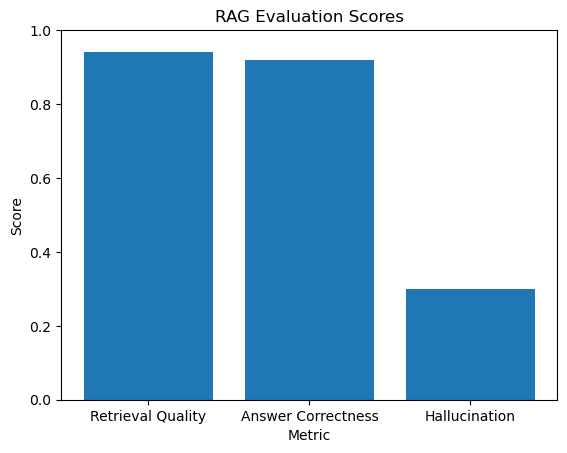

In [84]:
def plot_scores(scores):
    """
    Plot the evaluation scores.
    """
    labels = ["Retrieval Quality", "Answer Correctness", "Hallucination"]
    scores = [scores["retrieval_quality"], scores["answer_correctness"], scores["hallucination"]]
    
    _, ax = plt.subplots()
    ax.bar(labels, scores)
    ax.set_xlabel('Metric')
    # set y range to 0-1
    ax.set_ylim(0, 1)
    ax.set_ylabel('Score')
    ax.set_title('RAG Evaluation Scores')
    plt.show()

plot_scores(results["scores"])

In [85]:
results["individual_results"][:5]

[{'query': 'When was MadeUpCompany founded and where is it headquartered?',
  'retrieved_context': [Document(id='4b2b4488-cd9e-451c-8835-583f9617a416', metadata={'Header 1': 'About MadeUpCompany'}, page_content='[About MadeUpCompany]: \nMadeUpCompany is a pioneering technology firm founded in 2010, specializing in cloud computing, data analytics, and machine learning. Headquartered in San Francisco, California, we have a global presence with satellite offices in New York, London, and Tokyo. Our mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation.  \nWith a diverse team of experts from various industries—including AI research, cybersecurity, and enterprise software development—we push the boundaries of what’s possible. Our commitment to continuous improvement, security, and customer success has earned us recognition as a leader in the tech space.'),
   Document(id='891efd52-009b-4d26-9d2a-1a844c114030', meta

In [86]:
# Adjustment 2: Adjust LLM decoding parameters
llm.params[GenParams.TEMPERATURE] = 0.7
response = llm.invoke(formatted_prompt)
print(response)

 I don't know much about MadeUpCompany except that their website is www.madeupcompany.com and they have a sales email address (sales@madeupcompany.com). The provided documents only contain this basic contact information. There's no additional details available in the given context.


In [88]:
results = evaluate_rag_system(
    graph, 
    sample_queries,
    expected_responses,
    evaluator=RAGEvaluator(llm_func=call_judge),
    verbose=True
)

results["scores"]

  0%|          | 0/25 [00:00<?, ?it/s]

[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed, same facts' score=1


  4%|▍         | 1/25 [00:13<05:33, 13.89s/it]

[evaluation_hallucination] LLM response: reasoning='Answer fully supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


  8%|▊         | 2/25 [00:24<04:39, 12.15s/it]

[evaluation_hallucination] LLM response: reasoning='Mentions business continuity' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Equivalent content' score=1


 12%|█▏        | 3/25 [00:35<04:09, 11.32s/it]

[evaluation_hallucination] LLM response: reasoning='Extra information about plan position' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully described' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 16%|█▌        | 4/25 [00:47<04:04, 11.63s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact explicitly stated' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 20%|██        | 5/25 [00:57<03:44, 11.24s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 24%|██▍       | 6/25 [01:10<03:41, 11.64s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches document content' score=1
[evaluation_answer_correctness] LLM response: reasoning='Matches expected answer' score=1


 28%|██▊       | 7/25 [01:21<03:27, 11.51s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 32%|███▏      | 8/25 [01:32<03:13, 11.37s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupportable claims' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 36%|███▌      | 9/25 [01:43<02:57, 11.12s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is fully supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches company values' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 40%|████      | 10/25 [01:53<02:44, 11.00s/it]

[evaluation_hallucination] LLM response: reasoning='Minor inference, not direct quote' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 44%|████▍     | 11/25 [02:05<02:36, 11.17s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 48%|████▊     | 12/25 [02:15<02:21, 10.85s/it]

[evaluation_hallucination] LLM response: reasoning='Added unsuppoted plan analysis' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches document content' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 52%|█████▏    | 13/25 [02:29<02:20, 11.68s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 56%|█████▌    | 14/25 [02:42<02:13, 12.11s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is fully supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is accurate' score=1


 60%|██████    | 15/25 [02:52<01:55, 11.59s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is correct' score=1


 64%|██████▍   | 16/25 [03:03<01:42, 11.44s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is fully supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Encryption method mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 68%|██████▊   | 17/25 [03:15<01:32, 11.51s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is fully supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact found in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 72%|███████▏  | 18/25 [03:26<01:20, 11.50s/it]

[evaluation_hallucination] LLM response: reasoning='Mentions unfounded comparisons' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in all documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed, same core answer' score=1


 76%|███████▌  | 19/25 [03:38<01:09, 11.53s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 80%|████████  | 20/25 [03:49<00:57, 11.42s/it]

[evaluation_hallucination] LLM response: reasoning="Adds 'unusual patterns' detail" score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact is present' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 84%|████████▍ | 21/25 [04:02<00:47, 11.82s/it]

[evaluation_hallucination] LLM response: reasoning="Adds 'unused service time' detail" score=1
[evaluation_retrieval_quality] LLM response: reasoning='No trend forecasting mentioned' score=0
[evaluation_answer_correctness] LLM response: reasoning='Lacks specific information' score=0


 88%|████████▊ | 22/25 [04:14<00:35, 11.92s/it]

[evaluation_hallucination] LLM response: reasoning='No new info introduced' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Only flexible pricing mentioned' score=0
[evaluation_answer_correctness] LLM response: reasoning='Lacks specific details' score=0


 92%|█████████▏| 23/25 [04:27<00:24, 12.24s/it]

[evaluation_hallucination] LLM response: reasoning='Answer admits lack of knowledge' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 96%|█████████▌| 24/25 [04:41<00:12, 12.85s/it]

[evaluation_hallucination] LLM response: reasoning='Added unsuppported environmental impact detail' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


100%|██████████| 25/25 [04:55<00:00, 11.84s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by documents' score=0


{'retrieval_quality': 0.92, 'answer_correctness': 0.92, 'hallucination': 0.28}

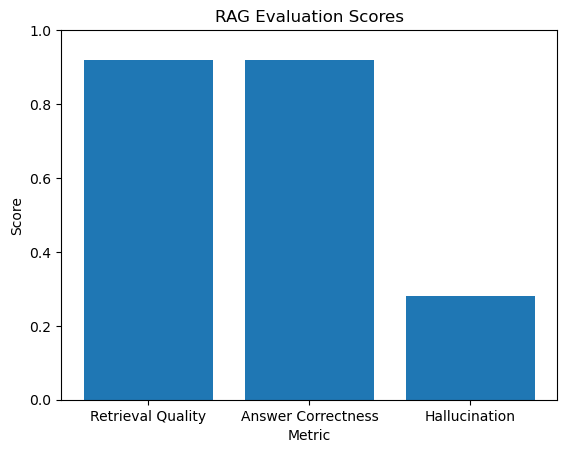

In [89]:
def plot_scores(scores):
    """
    Plot the evaluation scores.
    """
    labels = ["Retrieval Quality", "Answer Correctness", "Hallucination"]
    scores = [scores["retrieval_quality"], scores["answer_correctness"], scores["hallucination"]]
    
    _, ax = plt.subplots()
    ax.bar(labels, scores)
    ax.set_xlabel('Metric')
    # set y range to 0-1
    ax.set_ylim(0, 1)
    ax.set_ylabel('Score')
    ax.set_title('RAG Evaluation Scores')
    plt.show()

plot_scores(results["scores"])

In [90]:
results["individual_results"][:5]

[{'query': 'When was MadeUpCompany founded and where is it headquartered?',
  'retrieved_context': [Document(id='4b2b4488-cd9e-451c-8835-583f9617a416', metadata={'Header 1': 'About MadeUpCompany'}, page_content='[About MadeUpCompany]: \nMadeUpCompany is a pioneering technology firm founded in 2010, specializing in cloud computing, data analytics, and machine learning. Headquartered in San Francisco, California, we have a global presence with satellite offices in New York, London, and Tokyo. Our mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation.  \nWith a diverse team of experts from various industries—including AI research, cybersecurity, and enterprise software development—we push the boundaries of what’s possible. Our commitment to continuous improvement, security, and customer success has earned us recognition as a leader in the tech space.'),
   Document(id='891efd52-009b-4d26-9d2a-1a844c114030', meta

### Reflection

- Hyperparameter Tuning: The top-k parameter in the retrieval process was adjusted to experiment with the number of documents retrieved for context. Increasing top-k to 5 improved retrieval quality by providing more context, but further increases introduced irrelevant documents, reducing overall performance.
- Temperature: The temperature parameter for the LLM was modified to 0.7 to allow for more diverse and creative responses. This also reduced performance as more diverse outputs not necessarily is the parameter we are trying to improve.
- New models: other ideas for improvement could be to change the model to one with more parameters, as it (perhaps) would be able to process the inputs better.  